In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import deque
from scipy.stats import norm
%matplotlib inline

In [4]:
log_path = '/u200/Udacity/behavioral-cloning-project/data'
data_df = pd.read_csv(log_path+'/driving_log.csv')

In [5]:
data_df.iloc[:5]

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


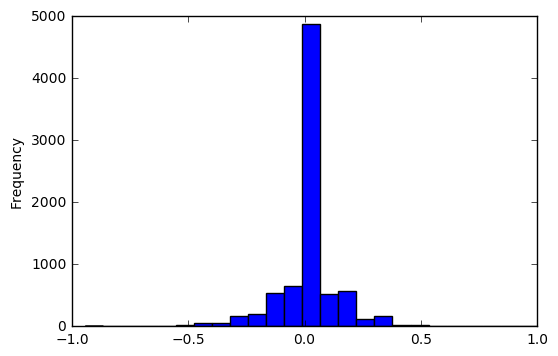

In [6]:
data_df['steering'].plot.hist(bins=25)

In [7]:
data_df['steering'].describe()

count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

In [8]:
data_df['brake'].value_counts()

0.000000    8003
1.000000       5
0.326939       3
0.414081       3
0.268844       2
0.394716       2
0.433446       2
0.811061       1
0.617412       1
0.036465       1
0.985345       1
0.375351       1
0.075195       1
0.191385       1
0.142972       1
0.336621       1
0.820743       1
0.443128       1
0.510905       1
0.220432       1
0.046148       1
0.026783       1
0.772331       1
Name: brake, dtype: int64

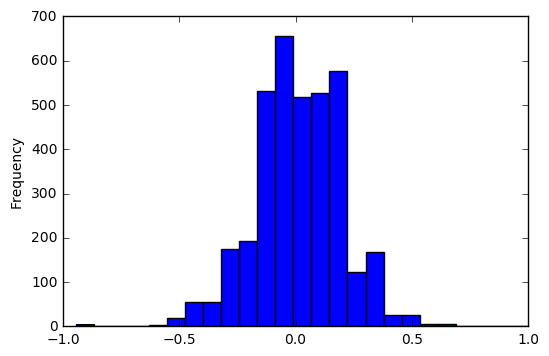

In [9]:
data_df.query('steering != 0')['steering'].plot.hist(bins=25)

In [10]:
def filter_driving_straight(data_df, hist_items=6):
    steering_history = deque([])
    
    drop_rows=[]
    
    for idx, row in data_df.iterrows():
        # controls = [getattr(row, control) for control in vehicle_controls]
        steering = getattr(row, 'steering')

        # record the recent steering history
        steering_history.append(steering)
        if len(steering_history) > hist_items:
            steering_history.popleft()

        # if just driving in a straight line continue
        if steering_history.count(0.0) == hist_items:
            drop_rows.append(idx)

    return data_df.drop(data_df.index[drop_rows])

In [11]:
# https://www.physicsforums.com/threads/steering-wheel-angle-radius-of-curvature.59881/

def one_over_r(steering_radians, steering_ratio=12., wheel_base=3.):   
    return np.sin(steering_radians/steering_ratio)/wheel_base

def steering_angle(one_over_r, steering_ratio=12., wheel_base=3.):
    a=one_over_r*wheel_base
    return np.arcsin(a)*steering_ratio
    
one_over_r(steering_angle(0.1))

0.10000000000000002

In [12]:
data_df2=filter_driving_straight(data_df)

In [13]:
data_df2=data_df2.assign(one_over_r=lambda x:[one_over_r(steering) for steering in x.steering])
data_df2.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed',
       'one_over_r'],
      dtype='object')

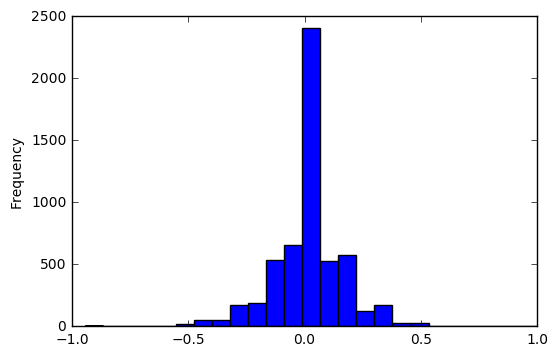

In [14]:
data_df2['steering'].plot.hist(bins=25)

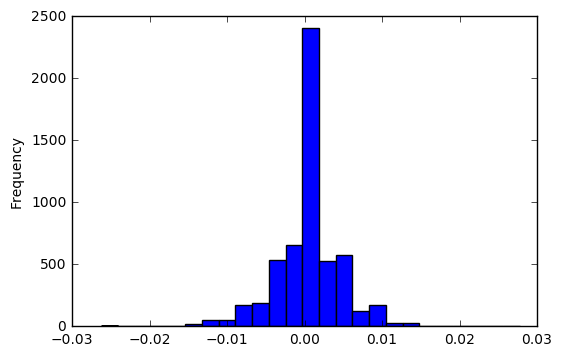

In [15]:
data_df2['one_over_r'].plot.hist(bins=25)

dont have enougth steering data and 1/r values too small 

In [16]:
len(data_df2.loc[data_df2['steering'] == 0.0])

1884

In [17]:
data_df2.describe()

,steering,throttle,brake,speed,one_over_r
count,5559.000000,5559.000000,5559.000000,5559.000000,5559.000000
mean,0.005883,0.888590,0.002100,28.828677,0.000163
std,0.154877,0.272463,0.040643,4.586150,0.004301
min,-0.942695,0.000000,0.000000,1.418236,-0.026159
25%,-0.059757,0.985533,0.000000,30.182030,-0.001660
50%,0.000000,0.985533,0.000000,30.186030,0.000000
75%,0.071328,0.985533,0.000000,30.186610,0.001981
max,1.000000,0.985533,1.000000,30.631810,0.027746


In [18]:
from pathlib import PurePosixPath
import cv2
import os
from datetime import datetime
import matplotlib.gridspec as gridspec

In [19]:
def image_files(path,camera='center'):
    return[path+f for f in os.listdir(path) if camera in str(f)]

In [20]:
center_camera_files=image_files(log_path+'/IMG/')
left_camera_files=image_files(log_path+'/IMG/',camera='left')
right_camera_files=image_files(log_path+'/IMG/',camera='right')

In [21]:
print(len(left_camera_files),len(center_camera_files),len(right_camera_files))

8036 8036 8036


In [22]:
print(left_camera_files[0])
print(center_camera_files[0])
print(right_camera_files[0])

p = PurePosixPath(left_camera_files[0])
split=p.stem.split('_')
camera=split.pop(0)
dts=np.asarray(split, dtype=np.int)
print(camera, dts, datetime(dts[0],dts[1],dts[2],dts[3],dts[4],dts[5],dts[6]))

/u200/Udacity/behavioral-cloning-project/data/IMG/left_2016_12_01_13_35_53_375.jpg
/u200/Udacity/behavioral-cloning-project/data/IMG/center_2016_12_01_13_40_05_910.jpg
/u200/Udacity/behavioral-cloning-project/data/IMG/right_2016_12_01_13_46_24_923.jpg
left [2016   12    1   13   35   53  375] 2016-12-01 13:35:53.000375


In [23]:
data_df.iloc[100]

center      IMG/center_2016_12_01_13_32_48_402.jpg
left          IMG/left_2016_12_01_13_32_48_402.jpg
right        IMG/right_2016_12_01_13_32_48_402.jpg
steering                                -0.0597572
throttle                                  0.985533
brake                                            0
speed                                      30.1869
Name: 100, dtype: object

In [24]:
def load_image(filename):
    filename = filename.strip()
    if filename.startswith('IMG'):
        filename = log_path+'/'+filename
    else:
        # load it relative to where log file is now, not whats in it
        filename = log_path+'/IMG/'+PurePosixPath(filename).name

    img = cv2.imread(filename)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

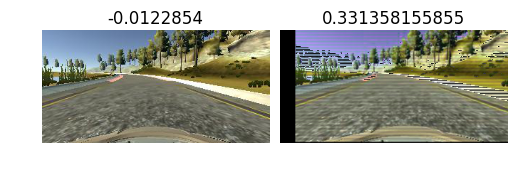

In [25]:
def randomise_image_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # brightness
    bv = .3 + np.random.random()
    hsv[::2] = hsv[::2]*bv

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    
# used this routine from https://github.com/mvpcom/Udacity-CarND-Project-3
def jitter_image_rotation(image, steering):
    rows, cols, _ = image.shape
    transRange = 50
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange/2
    steering = steering + transX/transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels/2
    transMat = np.float32([[1,0, transX], [0,1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return (image, steering)

def plot_jitter_sample(data_df, idx):
    logdata=data_df.iloc[idx]
    img1 = load_image(logdata.center)
    steering1 = logdata.steering
    img2, steering2 = jitter_image_rotation(img1, steering1)
    img2 = randomise_image_brightness(img2)
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,2,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.title(steering1)
    plt.axis('off')
    plt.imshow(img1)
    fig.add_subplot(gs1[1])
    plt.title(steering2)
    plt.axis('off')
    plt.imshow(img2)
    
plot_jitter_sample(data_df,5050)

In [26]:
def draw_cameras(img_left, img_center, img_right, telemetry):
    height = img_center.shape[0]
    width = img_center.shape[1]
    steering = telemetry['steering']
    
    txt='%.3f/%.3f' % (steering,one_over_r(steering))
    
    pad=np.zeros((height,10,3), np.uint8)
    
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(img_center,txt,(int(width/2)-75,height-20), font, 1,(255,255,255),1,cv2.LINE_AA)
    
    return np.hstack((img_left, pad, img_center, pad, img_right))

def plot_cameras(img_left, img_center, img_right):
    fig = plt.figure(dpi=200)
    gs1 = gridspec.GridSpec(1,3,wspace=0.05)
    fig.add_subplot(gs1[0])
    plt.imshow(img_left)
    plt.title('left')
    plt.axis('off')
    fig.add_subplot(gs1[1])
    plt.imshow(img_center)
    plt.title('center')
    plt.axis('off')
    fig.add_subplot(gs1[2])
    plt.imshow(img_right)
    plt.title('right')
    plt.axis('off')

In [27]:
import random

def get_telemetry(row):
    vehicle_controls = ['steering', 'throttle', 'brake']
    controls = {control:getattr(row, control) for control in vehicle_controls}
    return controls

def crop_camera(img, crop_height=66, crop_width=200):
    height = img.shape[0]
    width = img.shape[1]
    
#     y_start=60+random.randint(-10,10)
#     x_start=int(width/2)-int(crop_width/2)+random.randint(-40,40)
    y_start=60
    x_start=int(width/2)-int(crop_width/2)
    
    return img[y_start:y_start+crop_height,x_start:x_start+crop_width]
    
def load_and_plot(log_index):
    logdata=data_df.iloc[log_index]
    t=get_telemetry(logdata)
    img_left=load_image(logdata.left)
    img_center=load_image(logdata.center)
    img_right=load_image(logdata.right)
    plot_cameras(img_left, img_center, img_right)

def load_and_draw(log_index):
    logdata=data_df.iloc[log_index]
    t=get_telemetry(logdata)
    img_left=crop_camera(load_image(logdata.left))
    img_center=crop_camera(load_image(logdata.center))
    img_right=crop_camera(load_image(logdata.right))
    return draw_cameras(img_left, img_center, img_right,t)

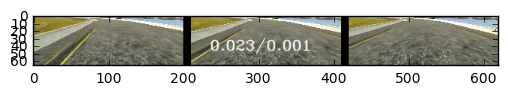

In [28]:
plt.imshow(load_and_draw(4300))

In [29]:
from moviepy.editor import *
from IPython.display import HTML

In [30]:
%time clip_data=[load_and_draw(idx) for idx in data_df2.index]

CPU times: user 10.9 s, sys: 264 ms, total: 11.1 s
Wall time: 11.1 s


In [31]:
clip_out='clip_sample.mp4'
clip = ImageSequenceClip(clip_data, fps=50)
%time clip.write_videofile(clip_out, audio=False)

[MoviePy] >>>> Building video clip_sample.mp4
[MoviePy] Writing video clip_sample.mp4


100%|██████████| 5559/5559 [00:18<00:00, 307.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: clip_sample.mp4 

CPU times: user 5.63 s, sys: 180 ms, total: 5.81 s
Wall time: 18.3 s


In [32]:
HTML("""
<video width="960" height="150" controls>
  <source src="{0}">
</video>
""".format(clip_out))

In [33]:
def create_movie_from_log(log_path,log_file='driving_log.csv',skiprows=0,clip_name='log_clip.mp4', sample_every=1):
    column_names = ['center', 'left', 'right',
                    'steering', 'throttle', 'brake', 'speed']
    data_df = pd.read_csv(log_path+'/'+log_file,
                          names=column_names, skiprows=skiprows)
    
    clip_data=[load_and_draw(idx) for idx in data_df.index if not idx % sample_every]
    clip = ImageSequenceClip(clip_data, fps=50)
    %time clip.write_videofile(clip_name, audio=False)

In [34]:
clip_name='udacity_sample.mp4'
create_movie_from_log('/u200/Udacity/behavioral-cloning-project/data',skiprows=1,clip_name=clip_name,sample_every=1)

[MoviePy] >>>> Building video udacity_sample.mp4
[MoviePy] Writing video udacity_sample.mp4


100%|██████████| 8037/8037 [00:28<00:00, 278.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: udacity_sample.mp4 

CPU times: user 12.1 s, sys: 432 ms, total: 12.5 s
Wall time: 29 s


In [35]:
HTML("""
<video width="960" height="150" controls>
  <source src="{0}">
</video>
""".format(clip_name))

In [36]:
clip_name='simulator_run1.mp4'
create_movie_from_log('./data',clip_name=clip_name, sample_every=1)

IndexError: single positional indexer is out-of-bounds

In [ ]:
HTML("""
<video width="960" height="150" controls>
  <source src="{0}">
</video>
""".format(clip_name))

In [ ]:
def augment_log_data(data_df,cname='steering'):
    mu = 0
    sigma = 0.2
    
    zero_total = len(data_df.loc[data_df[cname] == 0.0])
    print("zero angle total: ", zero_total)
    
    bin_len=15
    # bins with values from -1 to 1
    bin = np.linspace(-1, 1, bin_len)
    
    # middle bin is 0.0 steering angle
    assert bin[int(bin_len/2)] == 0.0
    
    for b in range(len(bin)):
        # select rows for this bin
        if bin[b] == 0.0:
            bd_count = zero_total
            bd_df = data_df[data_df[cname] == 0.0]
        elif bin[b] < 0.0:
            bd_df = data_df[data_df[cname].between(bin[b],bin[b+1]-0.0001)]
            bd_count=len(bd_df)
        else:
            bd_df = data_df[data_df[cname].between(bin[b-1]+0.0001,bin[b])]
            bd_count=len(bd_df)
        
        # work out count for a gausian distribution
        if b == int(bin_len/2):
            bd_desired=zero_total
        else:
            bd_desired=int((zero_total/2.) * norm.pdf(bin[b], mu, sigma))
     
        print("bin[%.2d] %s: %f count: %d desired: %d" % (b,cname,bin[b],bd_count,bd_desired))
        
        # append extra rows
        bd_needed = bd_desired - bd_count
        if bd_needed > 0 and bd_count > 0:
            bd_df=bd_df.sample(frac=(1.*bd_desired/bd_count), replace=True)
        
        # first time through save the dataframe for later bins to append to
        if b == 0:
            final_df = bd_df
            
        else:
            final_df = final_df.append(bd_df, ignore_index=True)
    
    return final_df      
        
a_df=augment_log_data(data_df2)
a_df['steering'].plot.hist(bins=15)